# The COVIDNetX challenge

<img src="https://www.psycharchives.org/retrieve/096175aa-f7f2-4970-989d-d934c30b5551" alt="drawing" width="400"/>

The following is a classification challenge using the [COVID-X dataset](https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md).
The goal is to predict whether a person has COVID-19 or not based on chest X-RAY images.

There are two different categories: `positive` and `negative`. `positive` means a person has COVID-19, `negative` means a person
has not COVID-19.

The metric we use is F1 (https://en.wikipedia.org/wiki/F1_score). The goal is to maximize F1.

The data contains images with their associated labels.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pickle

## Data Preprocessing

### Load Data

In [2]:
data_dir = 'data/'
# data_dir = 'data_subset/'

df = pd.read_csv(data_dir+'train.csv')
test_df = pd.read_csv(data_dir+'submission_valid.csv')

### Split Data

In [3]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)

In [4]:
train_df_pos = train_df[train_df.label=='positive']
train_df_neg = train_df[train_df.label=='negative']

### Data generator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 10000
dataAug = False

if dataAug:
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True)
else:
    datagen = ImageDataGenerator(
        rescale=1./255)
datagen_rescale = ImageDataGenerator(rescale=1./255)

train_pos_datagen = datagen.flow_from_dataframe(
    train_df_pos,
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=True)

train_neg_datagen = datagen_rescale.flow_from_dataframe(
    train_df_neg,
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=True)

valid_datagen = datagen_rescale.flow_from_dataframe(
    valid_df, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='binary',
    shuffle=True)

test_datagen = datagen_rescale.flow_from_dataframe(
    test_df, 
    data_dir+'train/', 
    target_size=(img_size,img_size), 
    x_col='image', 
    y_col='label', 
    batch_size=batch_size, 
    class_mode='binary',
    shuffle=True)

valid_datagen.class_indices

Found 1175 validated image filenames belonging to 1 classes.
Found 9958 validated image filenames belonging to 1 classes.
Found 1392 validated image filenames belonging to 2 classes.
Found 1392 validated image filenames belonging to 2 classes.


{'negative': 0, 'positive': 1}

In [7]:
%%time
processData = False

if processData:
    X_train_neg, _ = next(train_neg_datagen)
    X_train_pos, _ = next(train_pos_datagen)

    if dataAug:
        # Balancing the data by augmenting
        # only positive covid cases
        for _ in range(9):
            X, y = next(train_pos_datagen)
            X_train_pos = np.vstack((X_train_pos, X))

    X_train = np.vstack((X_train_pos, X_train_neg))
    y_train = np.concatenate((np.ones(len(X_train_pos)), np.zeros(len(X_train_neg))))

    X_valid, y_valid = next(valid_datagen)
    X_test, y_test = next(test_datagen)

    if dataAug:
        pickle.dump([X_train, y_train, X_valid, y_valid, X_test, y_test], open('data/data_w_DA.pkl', 'wb'))
    else:
        pickle.dump([X_train, y_train, X_valid, y_valid, X_test, y_test], open('data/data_wo_DA.pkl', 'wb'))

else:
    if dataAug:
        X_train, y_train, X_valid, y_valid, X_test, y_test = pickle.load(open('data/data_w_DA.pkl', 'rb'))
    else:
        X_train, y_train, X_valid, y_valid, X_test, y_test = pickle.load(open('data/data_wo_DA.pkl', 'rb'))

sum(y_train==1)/len(y_train), X_train.shape, X_train_neg.shape, X_valid.shape, X_test.shape

CPU times: user 3min 24s, sys: 35.8 s, total: 4min
Wall time: 8min 46s


(0.10554208209826642,
 (11133, 224, 224, 3),
 (9958, 224, 224, 3),
 (1392, 224, 224, 3),
 (1392, 224, 224, 3))

## Model

### Helper Function

In [8]:
def ml_metrics(ml_model):
    
    from sklearn.metrics import confusion_matrix, classification_report

    print("############################## TRAIN ############################## ")
    y_pred = ml_model.predict(X_train.reshape(featureShape))
    print(classification_report(y_train, y_pred))

    print("############################## VALID ############################## ")
    y_pred = ml_model.predict(X_valid.reshape(featureShape))
    print(classification_report(y_valid, y_pred))

    print("############################## TEST ############################## ")
    y_pred = ml_model.predict(X_test.reshape(featureShape))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, cmap='plasma', annot=True);

In [9]:
featureShape = tuple([-1,img_size*img_size*3])

### Random Forest

#### w/o data augmentation

In [11]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(n_estimators=100, min_samples_split=2,
                            random_state=42, n_jobs=-1, verbose=1)
                               
rf.fit(X_train.reshape(featureShape), y_train)
pickle.dump(rf, open('models/rf_wo_DA.pkl', 'wb'))

CPU times: user 10.3 ms, sys: 7.01 ms, total: 17.3 ms
Wall time: 28 ms


############################## TRAIN ############################## 


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9958
         1.0       1.00      1.00      1.00      1175

    accuracy                           1.00     11133
   macro avg       1.00      1.00      1.00     11133
weighted avg       1.00      1.00      1.00     11133

############################## VALID ############################## 


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1213
         1.0       0.91      0.65      0.76       179

    accuracy                           0.95      1392
   macro avg       0.93      0.82      0.87      1392
weighted avg       0.95      0.95      0.94      1392

############################## TEST ############################## 


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1236
         1.0       0.92      0.65      0.76       156

    accuracy                           0.95      1392
   macro avg       0.94      0.82      0.87      1392
weighted avg       0.95      0.95      0.95      1392



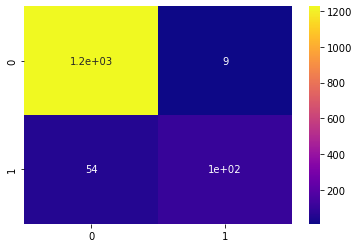

In [13]:
ml_metrics(pickle.load(open('models/rf_wo_DA.pkl', 'rb')))

#### w/ data augmentation

In [19]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(n_estimators=100, min_samples_split=2,
                            random_state=42, n_jobs=-1, verbose=1)
                               
rf.fit(X_train.reshape(featureShape), y_train)
pickle.dump(rf, open('models/rf_w_DA.pkl', 'wb'))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   37.6s


CPU times: user 29min 44s, sys: 51.4 s, total: 30min 35s
Wall time: 2min 21s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


############################## TRAIN ############################## 


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9958
         1.0       1.00      1.00      1.00     11750

    accuracy                           1.00     21708
   macro avg       1.00      1.00      1.00     21708
weighted avg       1.00      1.00      1.00     21708

############################## VALID ############################## 


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1213
         1.0       0.76      0.87      0.81       179

    accuracy                           0.95      1392
   macro avg       0.87      0.91      0.89      1392
weighted avg       0.95      0.95      0.95      1392

############################## TEST ############################## 


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      1236
         1.0       0.71      0.89      0.79       156

    accuracy                           0.95      1392
   macro avg       0.85      0.92      0.88      1392
weighted avg       0.95      0.95      0.95      1392



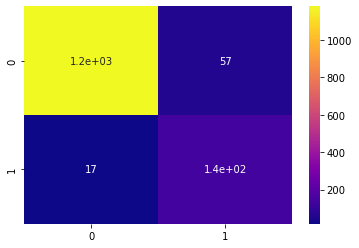

In [20]:
ml_metrics(pickle.load(open('models/rf_w_DA.pkl', 'rb')))

### XGBoost

#### w/o data augmentation

In [15]:
%%time

from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=200, random_state=42, learning_rate=0.2,
                    eval_metric='logloss', verbosity=1, use_label_encoder=False)

xgb.fit(X_train.reshape(featureShape), y_train, 
        eval_set=[(X_valid.reshape(featureShape), y_valid)], 
        early_stopping_rounds=10, verbose=1)
pickle.dump(xgb, open('models/xgb_wo_DA.pkl', 'wb'))

[0]	validation_0-logloss:0.55998
[1]	validation_0-logloss:0.47149
[2]	validation_0-logloss:0.40673
[3]	validation_0-logloss:0.35885
[4]	validation_0-logloss:0.32272
[5]	validation_0-logloss:0.29360
[6]	validation_0-logloss:0.26876
[7]	validation_0-logloss:0.25014
[8]	validation_0-logloss:0.23198
[9]	validation_0-logloss:0.21660
[10]	validation_0-logloss:0.20412
[11]	validation_0-logloss:0.19469
[12]	validation_0-logloss:0.18714
[13]	validation_0-logloss:0.18074
[14]	validation_0-logloss:0.17526
[15]	validation_0-logloss:0.16851
[16]	validation_0-logloss:0.16376
[17]	validation_0-logloss:0.15806
[18]	validation_0-logloss:0.15306
[19]	validation_0-logloss:0.14985
[20]	validation_0-logloss:0.14761
[21]	validation_0-logloss:0.14604
[22]	validation_0-logloss:0.14349
[23]	validation_0-logloss:0.14189
[24]	validation_0-logloss:0.13950
[25]	validation_0-logloss:0.13834
[26]	validation_0-logloss:0.13698
[27]	validation_0-logloss:0.13520
[28]	validation_0-logloss:0.13453
[29]	validation_0-loglos

############################## TRAIN ############################## 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9958
         1.0       1.00      1.00      1.00      1175

    accuracy                           1.00     11133
   macro avg       1.00      1.00      1.00     11133
weighted avg       1.00      1.00      1.00     11133

############################## VALID ############################## 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1213
         1.0       0.94      0.69      0.80       179

    accuracy                           0.95      1392
   macro avg       0.95      0.84      0.89      1392
weighted avg       0.95      0.95      0.95      1392

############################## TEST ############################## 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1236
         1.0       0.92      0.

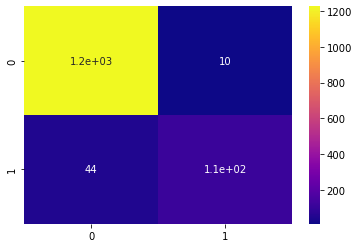

In [16]:
ml_metrics(pickle.load(open('models/xgb_wo_DA.pkl', 'rb')))

#### w/ data augmentation

In [10]:
%%time

from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=200, random_state=42, learning_rate=0.2,
                    eval_metric='logloss', verbosity=1, use_label_encoder=False)

xgb.fit(X_train.reshape(featureShape), y_train, 
        eval_set=[(X_valid.reshape(featureShape), y_valid)], 
        early_stopping_rounds=10, verbose=1)
pickle.dump(xgb, open('models/xgb_w_DA.pkl', 'wb'))

[0]	validation_0-logloss:0.59885
[1]	validation_0-logloss:0.52984
[2]	validation_0-logloss:0.47962
[3]	validation_0-logloss:0.43895
[4]	validation_0-logloss:0.40273
[5]	validation_0-logloss:0.37552
[6]	validation_0-logloss:0.35257
[7]	validation_0-logloss:0.33141
[8]	validation_0-logloss:0.31386
[9]	validation_0-logloss:0.30103
[10]	validation_0-logloss:0.28608
[11]	validation_0-logloss:0.27572
[12]	validation_0-logloss:0.26595
[13]	validation_0-logloss:0.25148
[14]	validation_0-logloss:0.24213
[15]	validation_0-logloss:0.23406
[16]	validation_0-logloss:0.22736
[17]	validation_0-logloss:0.22117
[18]	validation_0-logloss:0.21251
[19]	validation_0-logloss:0.20626
[20]	validation_0-logloss:0.20202
[21]	validation_0-logloss:0.19624
[22]	validation_0-logloss:0.19126
[23]	validation_0-logloss:0.18751
[24]	validation_0-logloss:0.18417
[25]	validation_0-logloss:0.17963
[26]	validation_0-logloss:0.17641
[27]	validation_0-logloss:0.17347
[28]	validation_0-logloss:0.17005
[29]	validation_0-loglos

############################## TRAIN ############################## 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9958
         1.0       1.00      1.00      1.00     11750

    accuracy                           1.00     21708
   macro avg       1.00      1.00      1.00     21708
weighted avg       1.00      1.00      1.00     21708

############################## VALID ############################## 
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1213
         1.0       0.86      0.85      0.86       179

    accuracy                           0.96      1392
   macro avg       0.92      0.92      0.92      1392
weighted avg       0.96      0.96      0.96      1392

############################## TEST ############################## 
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1236
         1.0       0.82      0.

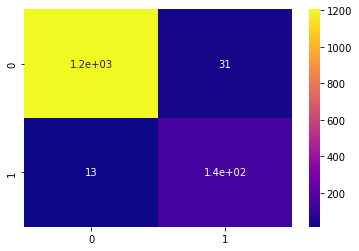

In [11]:
ml_metrics(pickle.load(open('models/xgb_w_DA.pkl', 'rb')))

## Submission

In [ ]:
submission_df.to_csv("submission.csv", index=False)

In [ ]:
!head submission.csv